In [1]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [3]:
from env import host, username, password

def get_db_url(database, host=host, user=username, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [4]:
# Read in grocery db from SQL
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
# Cluster on all or a selected subset of features
frozen_deli = df[["Frozen", "Delicassen"]]
frozen_deli.head(2)

,Frozen,Delicassen
customer_id,,
0,214,1338
1,1762,1776


In [6]:
# scale to mean of 0 
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(frozen_deli)

# Use the scaler
frozen_deli = scaler.transform(frozen_deli)
frozen_deli[:5]

array([[0.0031063 , 0.02784731],
       [0.02854842, 0.03698373],
       [0.03911643, 0.16355861],
       [0.10484189, 0.03723404],
       [0.063934  , 0.10809345]])

In [7]:
# constructing an DBScan object with min sample of 20 and radius of 0.1 core point
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(frozen_deli)

DBSCAN(eps=0.1, min_samples=20)

In [8]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Frozen", "Delicassen"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(frozen_deli, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Frozen,Scaled_Delicassen
0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.027847
1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.036984
2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.163559
3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.037234
4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.108093


In [9]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()

 0    433
-1      7
Name: labels, dtype: int64

In [10]:
df[df.labels==-1]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Frozen,Scaled_Delicassen,labels
23,2,3,26373,36423,22019,5154,4337,16523,0.084298,0.344597,-1
71,1,3,18291,1266,21042,5373,4173,14472,0.087897,0.301815,-1
87,1,3,43265,5025,8117,6312,1579,14351,0.103330,0.299291,-1
93,1,3,11314,3090,2062,35009,71,2698,0.574979,0.056216,-1
181,1,3,112151,29627,18148,16745,4948,8550,0.274801,0.178285,-1
183,1,3,36847,43950,20170,36534,239,47943,0.600043,1.000000,-1
325,1,2,32717,16784,13626,60869,1272,5609,1.000000,0.116938,-1


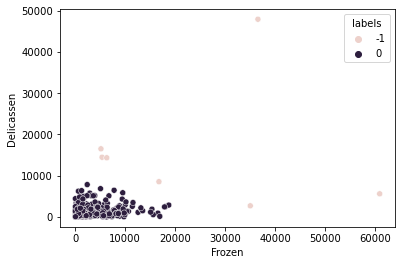

In [11]:
sns.scatterplot(df.Frozen, df.Delicassen, hue=df.labels)
plt.show()


Text(0.5, 0, 'Delicassen')

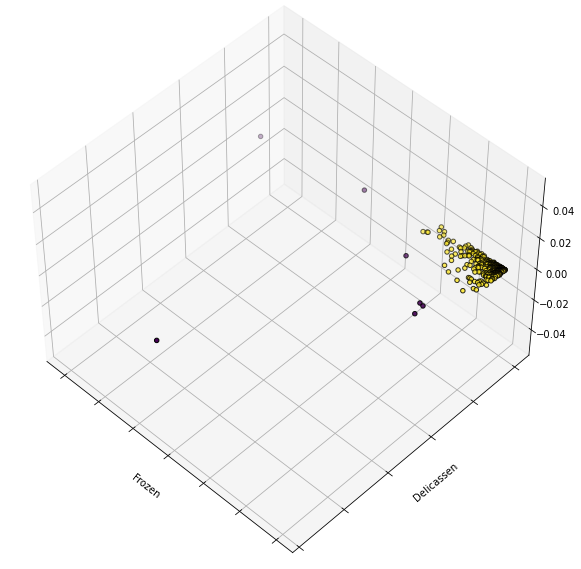

In [12]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Frozen, df.Delicassen,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])

ax.set_xlabel('Frozen')
ax.set_ylabel('Delicassen')


### Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [13]:
# Read in grocery db from SQL
url = get_db_url("curriculum_logs")

sql = """
select *
from logs
"""

df = pd.read_sql(sql, url)
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [14]:
# Explore
id_counts = df.groupby(['user_id'])['date','cohort_id','path'].nunique()
cohort_counts = df.groupby(['cohort_id'])['path','user_id','date'].nunique()
first_access = df.groupby(['user_id'])['date'].min()
id_by_first_access_date = pd.DataFrame({'first_access_date': first_access}).reset_index().groupby('first_access_date').count()

In [15]:
id_by_first_access_date

,user_id
first_access_date,
2018-01-26,50
2018-01-27,2
2018-01-28,2
2018-01-29,12
2018-01-30,7
...,...
2021-04-08,1
2021-04-11,1
2021-04-12,26


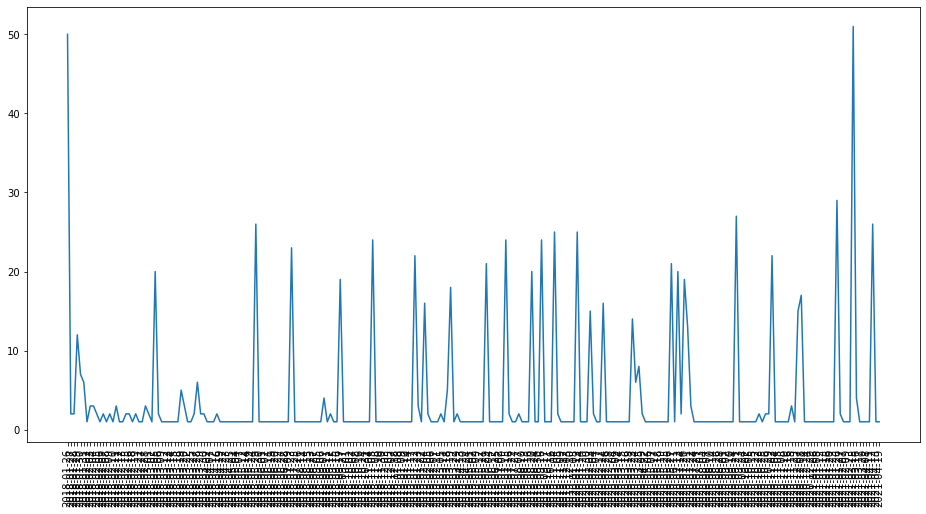

In [16]:
fig = plt.figure(figsize=(16, 8))
plt.plot(id_by_first_access_date)
plt.xticks(rotation = 90)
plt.show()

In [17]:
id_counts[id_counts.cohort_id > 1].head()

,date,cohort_id,path
user_id,,,
1,637,2,976
11,829,2,871
25,114,2,154
37,43,2,156
40,102,2,120


In [18]:
path_views = df.groupby(['user_id'])['path'].agg(['count','nunique'])
path_views.head()

,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197


In [23]:
scaler = MinMaxScaler().fit(path_views)
path_views_scaled = scaler.transform(path_views)
path_views_scaled[:5]

array([[0.41329835, 1.        ],
       [0.08597588, 0.15384615],
       [0.08714828, 0.17230769],
       [0.03857749, 0.14564103],
       [0.09490844, 0.20102564]])

In [24]:
# constructing an DBScan object with min sample of 20 and radius of 0.1 core point
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(path_views_scaled)

DBSCAN(eps=0.1, min_samples=20)

In [21]:
# add the scaled value columns back onto the dataframe
columns = list(path_views.columns)
path_views_scaled_columns = ["scaled_" + column for column in columns]
path_views_scaled_columns

['scaled_count', 'scaled_nunique']

In [25]:
# Create a dataframe containing the scaled values
scaled_path_df = pd.DataFrame(path_views_scaled, columns=path_views_scaled_columns)
scaled_path_df

,scaled_count,scaled_nunique
0,0.413298,1.000000
1,0.085976,0.153846
2,0.087148,0.172308
3,0.038577,0.145641
4,0.094908,0.201026
...,...,...
976,0.004745,0.011282
977,0.003015,0.017436
978,0.007034,0.019487
979,0.000112,0.000000


In [27]:
# Merge the scaled and non-scaled values into one dataframe
path_views = path_views.merge(scaled_path_df, on=path_views.index)

In [28]:
path_views = path_views.drop(columns=(['key_0']))

In [29]:
path_views

,count,nunique,scaled_count,scaled_nunique
0,7404,976,0.413298,1.000000
1,1541,151,0.085976,0.153846
2,1562,169,0.087148,0.172308
3,692,143,0.038577,0.145641
4,1701,197,0.094908,0.201026
...,...,...,...,...
976,86,12,0.004745,0.011282
977,55,18,0.003015,0.017436
978,127,20,0.007034,0.019487
979,3,1,0.000112,0.000000


In [30]:
# extract cluster labels
labels = dbsc.labels_
labels[:5]

array([-1,  0,  0,  0,  0])

In [31]:
# insert DBScan labels into df
path_views['labels'] = labels
path_views.labels.value_counts()

 0    973
-1      8
Name: labels, dtype: int64

In [32]:
# identify outliers
path_views[path_views.labels==-1]

,count,nunique,scaled_count,scaled_nunique,labels
0,7404,976,0.413298,1.000000,-1
10,17913,871,1.000000,0.892308,-1
52,12329,333,0.688254,0.340513,-1
63,16347,437,0.912573,0.447179,-1
247,5075,625,0.283274,0.640000,-1
313,7783,225,0.434457,0.229744,-1
494,6451,243,0.360094,0.248205,-1
580,6434,354,0.359145,0.362051,-1


In [33]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(path_views.describe())
print("-------------")
print("Outliers")
print(path_views[path_views.labels==-1].describe())

Population
              count     nunique  scaled_count  scaled_nunique      labels
count    981.000000  981.000000    981.000000      981.000000  981.000000
mean     917.657492  118.356779      0.051176        0.120366   -0.008155
std     1208.871322   80.781117      0.067489        0.082852    0.089982
min        1.000000    1.000000      0.000000        0.000000   -1.000000
25%      187.000000   53.000000      0.010384        0.053333    0.000000
50%      692.000000  140.000000      0.038577        0.142564    0.000000
75%     1297.000000  166.000000      0.072354        0.169231    0.000000
max    17913.000000  976.000000      1.000000        1.000000    0.000000
-------------
Outliers
              count     nunique  scaled_count  scaled_nunique  labels
count      8.000000    8.000000      8.000000        8.000000     8.0
mean    9967.000000  508.000000      0.556387        0.520000    -1.0
std     4921.341194  286.400818      0.274751        0.293744     0.0
min     5075.000000 

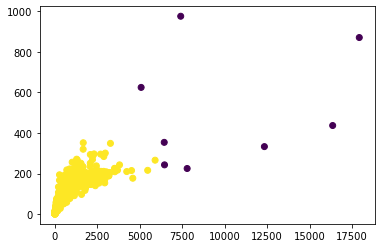

In [34]:
plt.scatter(path_views['count'], path_views['nunique'], c=path_views.labels)
plt.show()

Text(0.5, 0, 'nunique')

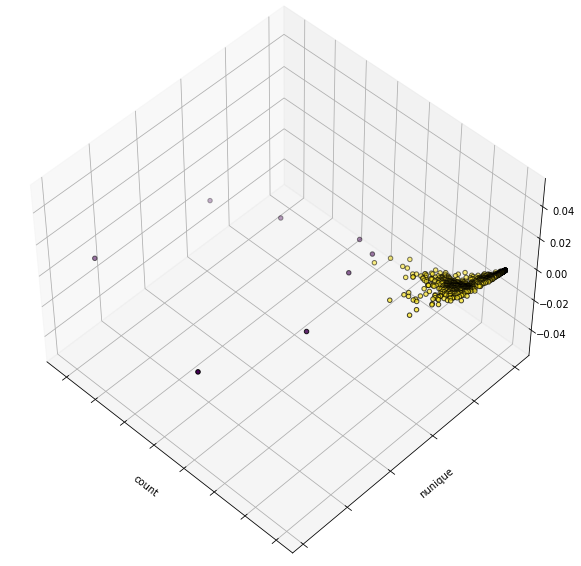

In [35]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(path_views['count'], path_views['nunique'],
           c=path_views.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])

ax.set_xlabel('count')
ax.set_ylabel('nunique')

### Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [36]:
df = pd.read_csv('zillow_data.csv')

In [37]:
def prep_zillow(df):
    
    ''' Single Unit Properties excluding shared structures'''
    # Restrict propertylandusedesc to those of single unit
    df = df[(df.propertylandusedesc == 'Single Family Residential') |
            (df.propertylandusedesc == 'Mobile Home') |
          (df.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes')]
    
    # dropping the columns with 17K missing values; too much to fill/impute/drop rows
    df = df.drop(columns=['heatingorsystemtypeid', 'buildingqualitytypeid', 'propertyzoningdesc', 'unitcnt', 'heatingorsystemdesc'])
    
    ##### transactiondate outlier #### 
    
    # address date outlier by replacing with mode
    df['transactiondate'] = df.transactiondate.replace('2018-05-25', '2017-06-30')
    
    # Convert transactiondate to datetime
    df['transactiondate'] = pd.to_datetime(df.transactiondate)
    
    # drop assessment year as it is one single year
    df = df.drop(columns=(['assessmentyear']))
    
    #dropping the id columns, as parcelid is a unique identifier
    df= df.drop(columns=('id'))
    
    # Convert logerror to absolute value
    df['logerror'] = df.logerror.abs()
    
    return df

In [38]:
df = prep_zillow(df)

In [42]:
# Cluster on all or a selected subset of features
zillow = df[["bedroomcnt", "calculatedfinishedsquarefeet"]]
zillow.isna().sum()

bedroomcnt                        0
calculatedfinishedsquarefeet    102
dtype: int64

In [45]:
zillow = zillow.dropna()

In [46]:
zillow.isna().sum()

bedroomcnt                      0
calculatedfinishedsquarefeet    0
dtype: int64

In [47]:
# scale to mean of 0 
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(zillow)

# Use the scaler
zillow_scaled = scaler.transform(zillow)
zillow_scaled[:5]

array([[0.28571429, 0.13632402],
       [0.14285714, 0.06132746],
       [0.21428571, 0.05114444],
       [0.28571429, 0.10311454],
       [0.28571429, 0.12999404]])

In [48]:
# constructing an DBScan object with min sample of 20 and radius of 0.1 core point
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(zillow_scaled)

DBSCAN(eps=0.1, min_samples=20)

In [52]:
# add the scaled value columns back onto the dataframe
columns = list(zillow.columns)
zillow_scaled_columns = ["scaled_" + column for column in columns]
zillow_scaled_columns

['scaled_bedroomcnt', 'scaled_calculatedfinishedsquarefeet']

In [54]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["bedroomcnt", "calculatedfinishedsquarefeet"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_zillow = zillow.copy()

# Create a dataframe containing the scaled values
scaled_zillow = pd.DataFrame(zillow_scaled, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
zillow_merge = zillow.merge(scaled_zillow, on=zillow.index)
zillow_merge = zillow_merge.drop(columns=['key_0'])
zillow_merge.head()

,bedroomcnt,calculatedfinishedsquarefeet,Scaled_bedroomcnt,Scaled_calculatedfinishedsquarefeet
0,4.0,3100.0,0.285714,0.136324
1,2.0,1465.0,0.142857,0.061327
2,3.0,1243.0,0.214286,0.051144
3,4.0,2376.0,0.285714,0.103115
4,4.0,2962.0,0.285714,0.129994


In [55]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
zillow_merge['labels'] = dbsc.labels_
zillow_merge.labels.value_counts()

 0    52460
-1       13
Name: labels, dtype: int64

In [56]:
# identify outliers
zillow_merge[zillow_merge.labels==-1]

,bedroomcnt,calculatedfinishedsquarefeet,Scaled_bedroomcnt,Scaled_calculatedfinishedsquarefeet,labels
589,0.0,5782.0,0.000000,0.259346,-1
4870,8.0,21929.0,0.571429,1.000000,-1
5743,14.0,18654.0,1.000000,0.849778,-1
16574,7.0,20612.0,0.500000,0.939590,-1
21991,11.0,4012.0,0.785714,0.178157,-1
27033,6.0,13598.0,0.428571,0.617862,-1
28122,6.0,15450.0,0.428571,0.702812,-1
29576,12.0,8469.0,0.857143,0.382597,-1
29577,12.0,8469.0,0.857143,0.382597,-1
29578,12.0,8469.0,0.857143,0.382597,-1


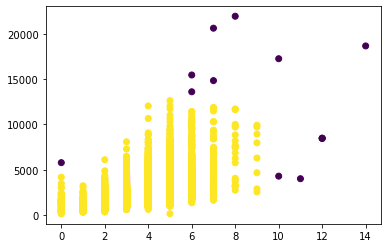

In [58]:
plt.scatter(zillow_merge['bedroomcnt'], zillow_merge['calculatedfinishedsquarefeet'], c=zillow_merge.labels)
plt.show()

Text(0.5, 0, 'calculatedfinishedsquarefeet')

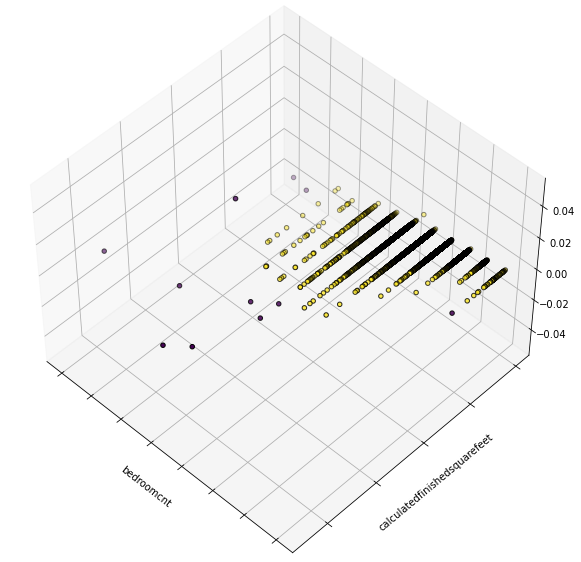

In [59]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(zillow_merge['bedroomcnt'], zillow_merge['calculatedfinishedsquarefeet'],
           c=zillow_merge.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])

ax.set_xlabel('bedroomcnt')
ax.set_ylabel('calculatedfinishedsquarefeet')